In [4]:
import sys

# import seaborn as sns
import numpy as np
from scipy import stats, integrate
import os
import matplotlib as mpl
import matplotlib.ticker as tk
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import re
from copy import deepcopy
from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import pandas as pd
import scipy.interpolate as interpolate
import json
import time

plt.rcParams.update({'font.size': 20})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
sys.path.append('/home/jtb34/GitHub/GACF/')
#sys.path.append('/home/jtb34/python27')
# print sys.path
from NGTS.NGTS_Field import return_field_from_object_directory, NGTSField
from NGTS.GACF_utils import TIME_CONVERSIONS
import NGTS.GACF_utils as utils

ROOT_DIR = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS'



In [2]:
XMATCH_LOCATION = '/home/jtb34/rds/hpc-work/GACF_OUTPUTS/{}/cross_match/'
XMATCH_FILE_NAME = 'Uncut_Final_{}.fits'
def load_gaia_params(field):
    xmatch_path = os.path.join(XMATCH_LOCATION.format(field.fieldname),
                               XMATCH_FILE_NAME.format(field.fieldname))
    if not os.path.exists(xmatch_path):
        print xmatch_path, 'does not exist'
        return field

    with fits.open(xmatch_path) as gfits:
        for i, obj in enumerate(gfits[1].data['Sequence_number']):
            if obj in field.objects:
                field[obj].Gaia_Teff = gfits[1].data['Gaia_Teff'][i]
                field[obj].Gaia_Radius = gfits[1].data['Gaia_Radius'][i]
                field[obj].Gaia_Lum = gfits[1].data['Gaia_Lum'][i]
                field[obj].Gaia_Parallax = gfits[1].data['Gaia_Parallax'][i]
                field[obj].TWOMASS_Hmag = gfits[1].data['2MASS_Hmag'][i]
                field[obj].TWOMASS_Kmag = gfits[1].data['2MASS_Kmag'][i]
                field[obj].APASS_Vmag = gfits[1].data['APASS_Vmag'][i]
                field[obj].APASS_Bmag = gfits[1].data['APASS_Bmag'][i]
                field[obj].Gaia_Gmag = gfits[1].data['Gaia_Gmag'][i]
                field[obj].Gaia_RPmag = gfits[1].data['Gaia_RPmag'][i]
                field[obj].Gaia_BPmag = gfits[1].data['Gaia_BPmag'][i]
                field[obj].NGTS_I_3 = gfits[1].data['NGTS_I_3'][i]
                field[obj].BminusV = field[obj].APASS_Bmag - field[obj].APASS_Vmag
                field[obj].HminusK = field[obj].TWOMASS_Hmag - field[obj].TWOMASS_Kmag
                field[obj].GminusK = field[obj].Gaia_Gmag - field[obj].TWOMASS_Kmag
                field[obj].BPminusRP = field[obj].Gaia_BPmag - field[obj].Gaia_RPmag
#         print gfits[1].header

    return field

def find_fits_file(directory=None):
    if directory is None:
         directory = os.getcwd()
    string_pattern = r'^(?P<fieldname>\w+?[+-]\w+?)_\d+_[\w\-/,]+_(?P<test>\w+).fits$'
    pattern = re.compile(string_pattern)
    for f in os.listdir(directory):
        match = re.match(pattern, f)
        if match is not None:
            return f if directory is None else os.path.join(directory, f), match.group('fieldname'), match.group('test')
        
    raise IOError('File not found in directory {}'.format(directory))
    
# field.load_from_fits(fits_file, obj_ids=object_list, method='fitsio')

In [5]:
pdics = {}
fieldnames = []
field_pattern = re.compile(r'^NG\d+[+|-]\d+$')

for f in os.listdir(ROOT_DIR):
    if re.match(field_pattern, f):
        fieldnames.append(f)
print "Found {} fields".format(len(fieldnames))
# print fieldnames
# fieldnames = fieldnames[1:5]
# fieldnames = ['NG2346-3633']

for field in fieldnames:
    field_dir = os.path.join(ROOT_DIR, field)
    pdic_filename = 'NGTS_Field_{}_pdic.json'.format(field)
    if pdic_filename in os.listdir(field_dir):
        with open(os.path.join(*[ROOT_DIR, field, pdic_filename])) as f:
            pdics[field] = json.load(f)
            pdics[field] = {int(k):v for k,v in pdics[field].iteritems()}
            

# fieldnames = pdics.keys()
# fieldnames = ['NG0004-2950']
# with open('/home/jtb34/rds/hpc-work/GACF_OUTPUTS/NG0535-0523/NGTS_Field_NG0535-0523_pdic.json', 'r') as f:
#     pdic = json.load(f)

# pdic = {int(k):v for k,v in pdic.iteritems()}


object_pattern = re.compile(r'^(?P<obj>\d+)_VERSION_CYCLE1807$')
obj_lists = {}
for field in fieldnames:
    obj_list = []
    for f in os.listdir(os.path.join(ROOT_DIR, field)):
        match = re.match(object_pattern, f)
        if match is not None:
            obj_list.append(int(match.group('obj')))
    obj_lists[field] = np.array(obj_list)
# print 'Found {} objects'.format(len(obj_list))
# print pdic

# half_moon_objs = [(k, v[0]) for k,v in pdic.iteritems() if 13<v[0]<15]
# print half_moon_objs

fieldsizes = {}
max_size = 0
for k, v in pdics.iteritems():
    print k, len(v), 'periods'
    fieldsizes[k] = float(len(v))
#     if fieldsizes[k] > max_size:
#         max_size = fieldsizes[k]
print

for k, v in obj_lists.iteritems():
    print k, len(v), 'objects'
    try:
        fieldsizes[k] = fieldsizes[k] / float(len(v))
        if fieldsizes[k] > max_size:
            max_size = fieldsizes[k]
    except KeyError:
        pass


Found 115 fields
NG0458-3056 73 periods
NG0535-0523 770 periods
NG0518-3633 84 periods
NG1429-3056 109 periods
NG2028-2518 94 periods
NG0523-0104 333 periods
NG0532-3633 80 periods
NG1114-3056 104 periods
NG1416-2518 58 periods
NG0450-3633 60 periods
NG0914-1652 125 periods
NG0613-3633 143 periods
NG1112-3345 128 periods
NG0304-1115 59 periods
NG0504-3633 80 periods
NG2346-3633 41 periods
NG1200-3633 126 periods
NG0931-1941 94 periods
NG0537-3056 74 periods
NG0511-3056 76 periods
NG0448-3922 70 periods
NG0531-0826 207 periods
NG2142+0826 95 periods
NG0445-3056 61 periods
NG2126-1652 65 periods
NG0612-2518 171 periods
NG0618-6441 260 periods
NG0549-3345 127 periods
NG0004-2950 115 periods
NG0409-1941 68 periods
NG0603-3056 148 periods
NG0456-3345 82 periods
NG0522-2518 112 periods
NG0603-3345 137 periods
NG2331-3922 45 periods
NG0509-3345 77 periods
NG0348-3345 56 periods
NG0524-3056 91 periods
NG0502-3922 70 periods
NG0616-3345 715 periods
NG0353-3056 59 periods

NG0458-3056 5881 objec

In [8]:
obj_ids = [44284]

In [9]:
fields = {}
# gfields = {}

for fieldname in fieldnames:
    if fieldname != 'NG0612-2518':
        continue
    t1 = time.time()
    try:
        field = return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807',
                                                   obj_ids = obj_ids, #pdics[fieldname].keys(),
                                                   include_empty_objects=False, silent=True)
    except KeyError:
        print 'No data loaded for field {}'.format(fieldname)
        continue
#     field = NGTSField(fieldname=fieldname, test='CYCLE1807', object_list=pdics[fieldname].keys())
    t2 = time.time()
    field = load_gaia_params(field)
    t3 = time.time()
    for obj in field:
        try:
            obj.cleaned_refined_periods = pdics[fieldname][obj.obj]
        except KeyError:
            obj.cleaned_refined_periods = None
    
#     gfield = NGTSField(fieldname=fieldname, test='CYCLE1807', object_list=obj_lists[fieldname])
#     gfield = load_gaia_params(gfield)
    
    fields[fieldname] = field
    t4 = time.time()
#     gfields[fieldname] = gfield

    fits_file, _, _ = find_fits_file(os.path.join(ROOT_DIR, fieldname))
    field.load_from_fits(fits_file, obj_ids=field.objects.keys(), method='fitsio', sparse_ids=True)
    field.get_new_moon_epoch()
    
    t5 = time.time()

#     print '{} objects with periods, {} total'.format(field.num_objects, gfield.num_objects)
    print 'Loaded field in {} seconds'.format(t2 - t1)
    print 'Loaded Gaia params in {} seconds'.format(t3 - t2)
    print 'Loaded NGTS data in {} seconds'.format(t5 - t4)
    print 'Finished Field in {} seconds'.format(t5 - t1)
fieldnames = fields.keys()

matched 13430 of 13976 files. Loaded 0 objects
/home/jtb34/rds/hpc-work/GACF_OUTPUTS/NG0612-2518/cross_match/Uncut_Final_NG0612-2518.fits does not exist


ValueError: min() arg is an empty sequence

In [42]:
xmatch_ids = {}
xmatch_paths = [os.path.join(XMATCH_LOCATION.format(fieldname),
                               XMATCH_FILE_NAME.format(fieldname)) for fieldname in fieldnames]
for xmatch_path, fieldname in zip(xmatch_paths, fieldnames):
    with fits.open(xmatch_path) as gfits:
        xmatch_ids[fieldname] = {k: v for k, v in zip(map(int,gfits[1].data['Sequence_number']), gfits[1].data['Gaia_Source_ID'])}

# only take relevant cross matches
for k, v in xmatch_ids.iteritems():
    obj_list = fields[k].objects.keys()
    xmatch_ids[k] = {k1: v1 for k1, v1 in v.iteritems() if k1 in obj_list}
    v = xmatch_ids[k]
    print k, len(v), 'Gaia xmatches'
    
# print xmatch_ids

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i + n]

from astroquery.utils.tap.core import TapPlus
from astroquery.gaia import Gaia
# gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
gaia_ids = []
for f, v in xmatch_ids.iteritems():
    for g in v.values():
        if g > 0:
            gaia_ids.append(g)
print 'Processing {} Gaia Ids'.format(len(gaia_ids))
max_rows = 5000
gaia_ids = [e for e in chunks(gaia_ids, max_rows)]
# gaia_ids = ', '.join(map(str, gaia_ids))
# print ', '.join(map(str, gaia_ids[:5]))
results = []
for gids in gaia_ids:
    job_str =  "SELECT source_id, dist.r_est, dist.r_lo, dist.r_hi, dist.r_len, \
                dist.result_flag, dist.modality_flag \n \
                FROM external.gaiadr2_geometric_distance as dist \n \
                JOIN gaiadr2.gaia_source AS src USING (source_id) \n \
                WHERE source_id IN ({})".format(', '.join(map(str, gids)))
    # print job_str
    job = Gaia.launch_job_async(job_str)
    results.append(job.get_results())
# print r

distance_dics = [{k:v for k,v in zip(map(int, r['source_id'].tolist()), r['r_est'].tolist())} for r in results]
distances =  {k: v for d in distance_dics for k, v in d.items()}

NG0518-3633 36 Gaia xmatches
Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Processing 36 Gaia Ids
Query finished.


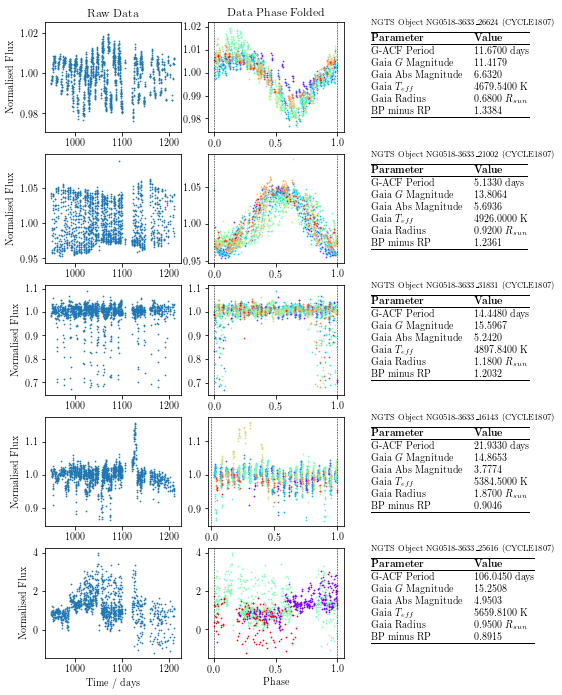

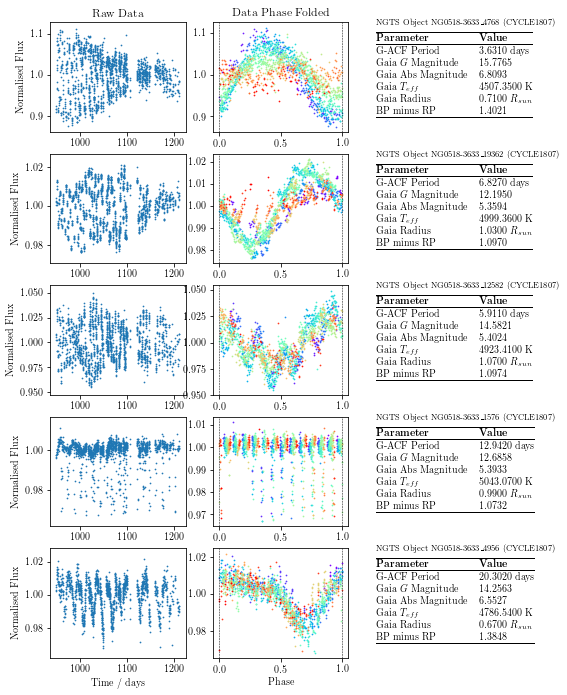

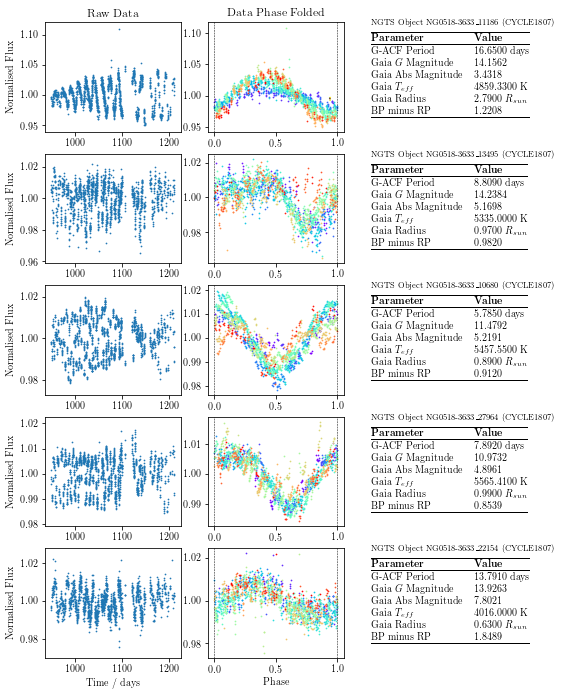

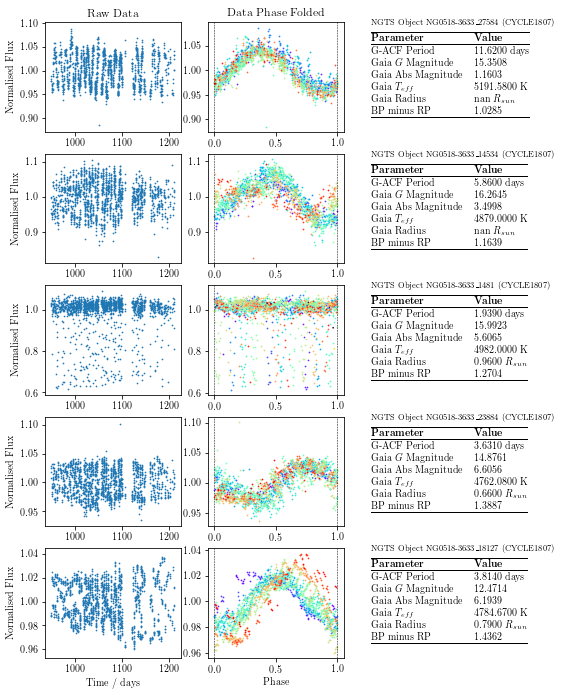

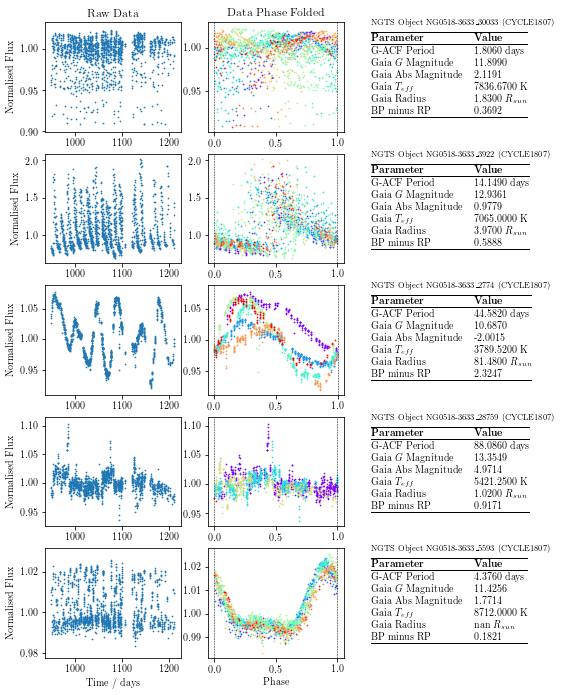

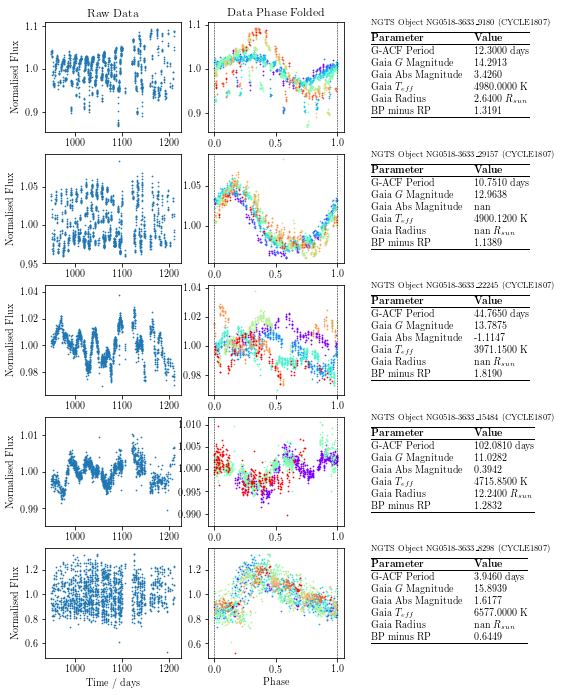

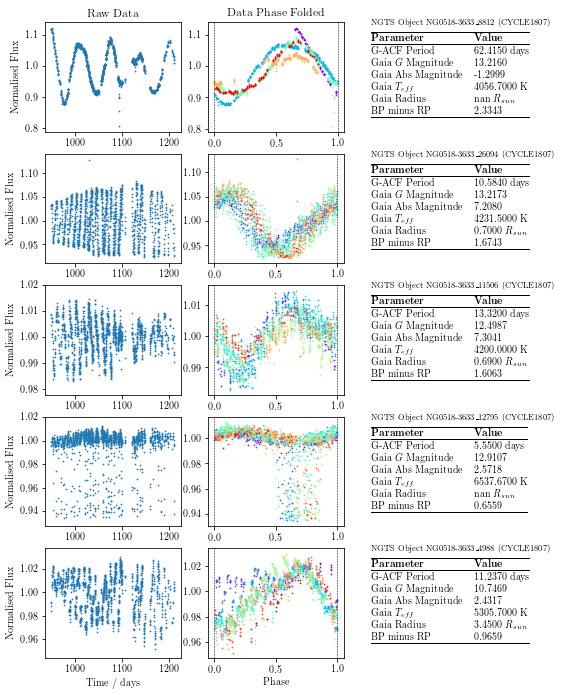

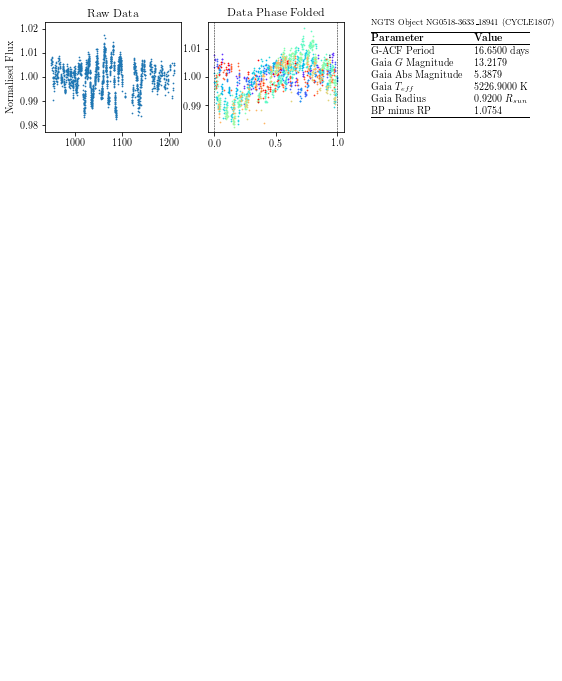

In [43]:
n_per_page = 5
with PdfPages('Object_Outputs.pdf') as pdf:
    for fieldname, field in fields.iteritems():
        num_pages = field.num_objects // n_per_page + 1
        for pagecount in range(num_pages):
            page = plt.figure(figsize=(8.27, 11.69))
            # height_ratios = [1, 1]
            # width_ratios = [1, 1]
            gs = gridspec.GridSpec(ncols=3, nrows=5)#, height_ratios=height_ratios, width_ratios=width_ratios)
            data_axs = []
            phase_axs = []
            table_axs = []

            for i in range(5):

                ax_data = page.add_subplot(gs[i, 0])
                ax_phase = page.add_subplot(gs[i, 1])
                ax_table = page.add_subplot(gs[i, 2])

                try:
                    obj = field[field.objects.keys()[pagecount*n_per_page + i]]
                except (KeyError, IndexError) as e:
                    ax_data.axis('off')
                    ax_phase.axis('off')
                    ax_table.axis('off')
                    continue
                    
                try:
                    obj.gaia_source_id = xmatch_ids[fieldname][obj.obj]
                    obj.distance = distances[obj.gaia_source_id]
        #             obj.distance = np.divide(1000., obj.Gaia_Parallax)
                    obj.Abs_Gmag = obj.Gaia_Gmag - 5 * np.log10(obj.distance) + 5
                except (KeyError, AttributeError, Exception) as e:
                    obj.distance = None
                    obj.Abs_Gmag = None
                radius = (float(obj.Gaia_Radius) if obj.Gaia_Radius is not None else np.nan)
                try:
                    abs_mag = (float(obj.Abs_Gmag) if obj.Abs_Gmag is not None else np.nan)
                except AttributeError:
                    abs_mag = np.nan

                p = obj.cleaned_refined_periods[0]
                Tex_Title = str(obj).replace('_', '\_')
                TeX_Table = r"""\begin{table}[]
                                             \begin{tabular}{@{}ll@{}}
                                             \hline
                                             \textbf{Parameter} & \textbf{Value} \\ \hline
                                             G-ACF Period & {%.4f} days          \\
                                             Gaia $G$ Magnitude & {%.4f}           \\
                                             Gaia Abs Magnitude & {%.4f}           \\
                                             Gaia $T_{eff}$     & {%.4f} K           \\
                                             Gaia Radius     & {%.4f} $R_{sun}$      \\
                                             BP minus RP          & {%.4f}           \\ \hline
                                             \end{tabular}
                                             \end{table}""".replace('\n', ' ') % (float(p),
                                                                                  float(obj.Gaia_Gmag), abs_mag,
                                                                                  float(obj.Gaia_Teff),
                                                                                  radius,
                                                                                  float(obj.BPminusRP))

                ax_table.axis('off')
                ax_table.text(0, 0.5, TeX_Table, size=10, va='center')
                ax_table.text(0, 1, Tex_Title, size=8, va='center')

                ax_data.scatter(obj.timeseries_binned, obj.flux_binned, s=0.5)
                if i == 0:
                    ax_data.set_title('Raw Data')
                    ax_phase.set_title('Data Phase Folded')
                if i == 4:
                    ax_data.set_xlabel('Time / days')
                    ax_phase.set_xlabel('Phase')
                ax_data.set_ylabel('Normalised Flux')

                t = obj.timeseries_binned
                f = obj.flux_binned
                phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, field.new_moon_epoch), f, 0)
                binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)

                ndata = len(phase_app)
                idx = [i for i in range(1,ndata) if phase_app[i]<phase_app[i-1] ]
                idx.append(ndata-1)
                nidx = len(idx)
                colours = mpl.cm.rainbow(np.r_[0:1:nidx*1j])
                phases, fs = [], []
                j=0
                for k,i in enumerate(idx):
                    phases.append( np.array(phase_app[j:i]) )
                    fs.append( np.array(f[j:i]) )
                    ax_phase.scatter(phases[k], fs[k], marker='o', s=0.5, c=colours[k])
                    j=i

                ax_phase.axvline(x=0, lw=0.5, c='k', ls='--')
                ax_phase.axvline(x=1, lw=0.5, c='k', ls='--')

            # ax_info = page.add_subplot(gs[0, :])
            # ax_plt = page.add_subplot(gs[1, 0])
            # ax_hr = page.add_subplot(gs[1, 1])

            pdf.savefig()
            
    d = pdf.infodict()
    d['Title'] = 'G-ACF Periods for NGTS Objects'
    d['Author'] = 'Joshua Briegal'
    d['CreationDate'] = datetime.datetime.today()